# Clumpy ensemble

The method utilised in `kosmatau3d` to simulate a clumpy ISM with velocity dispersion $\sigma_{ens}$ in a voxel is to use a fractal ensemble, that is, to use many smaller self-similar clumps with intrinsic velocity dispersion $\sigma_{cl}$. Each clump thus also contributes to the emissivity and opacity at each observing velocity. The discretisation is shown below.

$$
\Delta N_{j,i} \equiv \frac{N_j}{\sqrt{2 \pi \sigma_{ens}^2}} \mathrm{exp} \left( -\frac{(v_{vox} - v_i)^2}{2\sigma_{ens}^2} \right) \delta v_j,
$$

where $j$ refers to a particular clump mass, $i$ refers to the velocity of the clump, and $vox$ refers to the average value for the voxel (so a voxel with $v_{vox} = 0$ would have a Gaussian velocity distribution centered at 0).

Each clump has an emissivity and opacity that follow Gaussian distributions with velocity dispersion $\sigma_{cl}$. Thus the clumps at one systematic velocity will contribute distributions to the emissivity and opacity depending on the observing velocity:

$$
\epsilon_{ens}, \kappa_{ens} \propto \mathrm{exp} \left( - \frac{(v_{i} - v_{obs})^2}{2 \sigma_{cl}^2} \right).
$$

Due to the two distributions that contribute to the ensemble emissivity and opacity, the final distributions will have a larger effective velocity dispersion:

$$
\sigma_{ens, eff} \equiv \sqrt{\sigma_{ens}^2 + \sigma_{cl}^2}.
$$

## 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import Markdown as md

In [2]:
# Ensemble properties
ens_test = False
if ens_test:
    n_j = [2, 10] # Using [5, 100] gives a very strange result
    eps_j = [10, 1]
    kap_j = [1.5, 0.5]
    r_j = [0.5, 0.1]
else:
    n_j = [2]
    eps_j = [10]
    kap_j = [1.5]
    r_j = [0.5]
sigma_cl = 0.71
sigma_ens = 1
sigma_ens_tot = np.linalg.norm((sigma_cl, sigma_ens))
n_gauss = 5
n_v = 10
v_vox = 0
ds = 1

# Flags & plotting
mpl.rcParams['text.usetex'] = True
figsize = (10, 10)
fontsize = 20
legend_factor = 4/5
old_computation = False
incorrect_computation = False
test_opacity = False
plot_all = True

## 

In [3]:
sigma_ens_tot

1.2264175471673584

In [4]:
md(r'Below we will examine how this discretisation functions for and ensemble with $\sigma_{ens} =$'
   + '{}'.format(sigma_ens) + r'$\frac{km}{s}$ and ' + '{}'.format(n_j) + r' clumps, each with $\sigma_{cl} =$'
   + '{}'.format(sigma_cl) + r'$\frac{km}{s}$, $\epsilon_\nu =$'
   + '{}'.format(eps_j) + r'$\frac{K}{pc}$, $\kappa_\nu =$'
   + '{}'.format(kap_j) + r'$\frac{1}{pc}$, and a line-of-sight depth of $\Delta s =$'
   + '{}'.format(ds) + r'$pc$. This is enough to cause absorption features.')

Below we will examine how this discretisation functions for and ensemble with $\sigma_{ens} =$1$\frac{km}{s}$ and [2] clumps, each with $\sigma_{cl} =$0.71$\frac{km}{s}$, $\epsilon_\nu =$[10]$\frac{K}{pc}$, $\kappa_\nu =$[1.5]$\frac{1}{pc}$, and a line-of-sight depth of $\Delta s =$1$pc$. This is enough to cause absorption features.

In [5]:
def delta_n_ji(n_j, sigma_ens, sigma_cl=0.71, v_i=None, n_v=None, v_vox=0, n_gauss=4):
    
    if not n_v:
        n_v = 1
    if not isinstance(v_i, np.ndarray):
        dv = np.minimum(sigma_ens/n_v, sigma_cl/n_v)
        v_i = np.linspace(np.floor(-n_gauss*sigma_ens), np.ceil(n_gauss*sigma_ens), num=int(np.round(2*n_gauss*sigma_ens/dv))+1)
    
    if isinstance(n_j, int) or isinstance(n_j, float):
        n_j = np.asarray([[n_j]])
    elif isinstance(n_j, list):
        n_j = np.asarray(n_j)
    if n_j.ndim == 1:
        n_j = np.asarray([n_j]).reshape(-1, 1)
    
    dv = v_i[1]-v_i[0]
    delta_n = np.asarray([n / np.sqrt(2*np.pi*sigma_ens**2) * np.exp(-(v_vox-v_i)**2/2/sigma_ens**2) for n in n_j])
    # delta_n = delta_n * (n_j / delta_n.sum()) / dv
    return delta_n, v_i

In [6]:
from scipy.stats import binom

def probability(r_cl, ds=1, delta_n_ji=1):
    
    # Note: this is only valid for an ensemble of 1 clump size. Larger ensembles will need to use more-sophisticated arrays
    # if not isinstance(r_cl, int) and not isinstance(r_cl, float):
    #     print('Error: the ensemble can only be calculated for one clump type.')
    #     exit()
        
    if isinstance(r_cl, int) or isinstance(r_cl, float):
        r_cl = np.asarray([[r_cl]])
    elif isinstance(r_cl, list):
        r_cl = np.asarray(r_cl)
    if r_cl.ndim == 1:
        r_cl = np.asarray([r_cl]).reshape(-1, 1)
        
    if isinstance(delta_n_ji, int) or isinstance(delta_n_ji, float):
        delta_n_ji = np.asarray([[delta_n_ji]])
    elif isinstance(delta_n_ji, list):
        delta_n_ji = np.asarray(delta_n_ji)
    if delta_n_ji.ndim == 1: #not isinstance(delta_n_ji[0], list) or not isinstance(delta_n_ji[0], np.ndarray):
        delta_n_ji = np.asarray([delta_n_ji])
        
    p_j = np.pi*r_cl**2/ds**2
        
    factor = np.asarray([[delta_n_ji[cl, i] / np.ceil(delta_n_ji[0, i]) for i in range(delta_n_ji.shape[1])] for cl in range(delta_n_ji.shape[0])]) #np.ones_like(ensemble_n) #
    # print(np.shape(factor))
    k_ji_list = [[np.arange(int(np.ceil(delta_n_ji[cl, i]/factor[cl, i]))+1) for cl in range(delta_n_ji.shape[0])] for i in range(delta_n_ji.shape[1])]
    # print(len(k_ji_list), len(k_ji_list[120]), k_ji_list[120][0].shape)
    # print(r_cl.shape, delta_n_ji.shape)
    # for i in range(len(k_ji_list)):
    #     print(len(k_ji_list[i]))
    #     for k in np.meshgrid(*k_ji_list[i]):
    #         print()
    k_ji = np.asarray([[k.flatten() for k in np.meshgrid(*k_ji_list[i])] for i in range(len(k_ji_list))], dtype=object)
    # k_ji = np.zeros((k_ji_temp[1], k_ji_temp[0]), dtype=object)
    # for cl in range(k_ji.shape[0]):
    #     for i in range(k_ji.shape[1]):
    #         k_ji = 
    # print(k_ji.shape, '\n', k_ji)
    # print(delta_n_ji.shape, '\n', delta_n_ji)
    # print(factor.shape, '\n', factor)
    # for cl in range(delta_n_ji.shape[0]):
    #     for i in range(delta_n_ji.shape[1]):
    #         print(k_ji[i, cl], np.ceil(delta_n_ji[cl, i]), factor[cl, i], k_ji[i, cl].astype(int).dtype, np.ceil(delta_n_ji[cl, i]).dtype, (p_j[cl]*factor[cl, i]).dtype)
    p_ji = np.asarray([[binom.pmf(k_ji[i, cl].astype(int), np.ceil(delta_n_ji[cl, i]), p_j[cl, 0]*factor[cl, i]) for i in range(delta_n_ji.shape[1])] for cl in range(delta_n_ji.shape[0])], dtype=object)
    
    return p_ji, np.swapaxes(k_ji, 0, 1)

In [7]:
ensemble_n, v_i = delta_n_ji([100, 1], 3, v_vox=0, n_gauss=3, n_v=10)

In [8]:
prob, k_ji = probability([0.1, 0.5], 1, ensemble_n)

In [9]:
v_i = np.linspace(-10, 10, num=21)
ensemble_n, v_i = delta_n_ji(2, sigma_ens, v_i=v_i, v_vox=0, n_gauss=3, n_v=10)

In [10]:
prob, k_ji = probability(r_j, 1, ensemble_n)

In [11]:
i = 0
p_j = np.array([prob[j, i] for j in range(prob.shape[0])], dtype=float)
k_j = np.array([k_ji[j, i] for j in range(k_ji.shape[0])], dtype=int)
k_j.shape

(1, 2)

In [12]:
k_ji

array([[[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]]], dtype=object)

## Discretisation

### Examining the original discretisation

In the work of Andree-Labsch et al. (2017), the spacing of the clumps in the ensemble was the same as the observing velocities, namely $\delta v = 1 \frac{km}{s}$. Since each clump had $\sigma_{cl} \approx 0.71 \frac{km}{s}$, this discretisation was reasonable (though still not correct). In the current version of `kosmatau3d`, an internal velocity grid is created for the clumps in the ensemble with a velocity spacing of $\delta v = \mathrm{min} \left( \frac{\sigma_{ens}}{n_{velocity}}, \frac{\sigma_{cl}}{n_{velocity}} \right)$ with $n_{velocity} = 3$ being a reasonable approximation. For $\sigma_{ens},\sigma_{cl} < n_{velocity} \times 1 \frac{km}{s}$, this discretisation approximation gets worse and the resulting emissivity and opacity will be over-estimated.

In [13]:
v_i = np.linspace(-10, 10, num=21)
dv = v_i[1]-v_i[0]
ensemble_n, v_i = delta_n_ji(n_j, sigma_ens, v_i=v_i, v_vox=v_vox, n_gauss=n_gauss, n_v=n_v)

In [14]:
ensemble_n.sum() * dv

2.0000000107011524

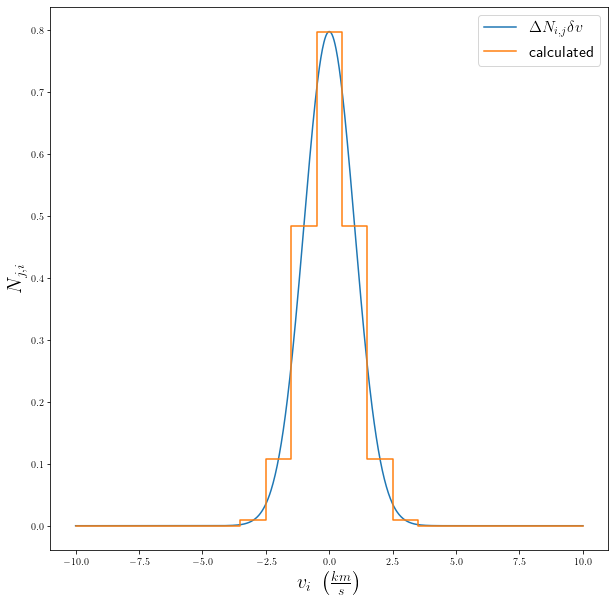

In [15]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

v = np.linspace(v_vox-10, v_vox+10, num=1000)
n = np.sum([n / np.sqrt(2*np.pi*sigma_ens**2) * np.exp(-(v_vox-v)**2/2/sigma_ens**2) for n in n_j], axis=0)
ax.plot(v, n, label=r'$\Delta N_{i,j} \delta v$')
ax.step(v_i, ensemble_n.sum(0), where='mid', label='calculated')
ax.set_xlabel(r'$v_i \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
ax.set_ylabel(r'$N_{j,i}$', fontsize=fontsize)
ax.legend(fontsize=fontsize*legend_factor) ;

Integrated intensity (no discretisation): 14.603788949754605
Integrated intensity (with discretisation): 14.60380560387605


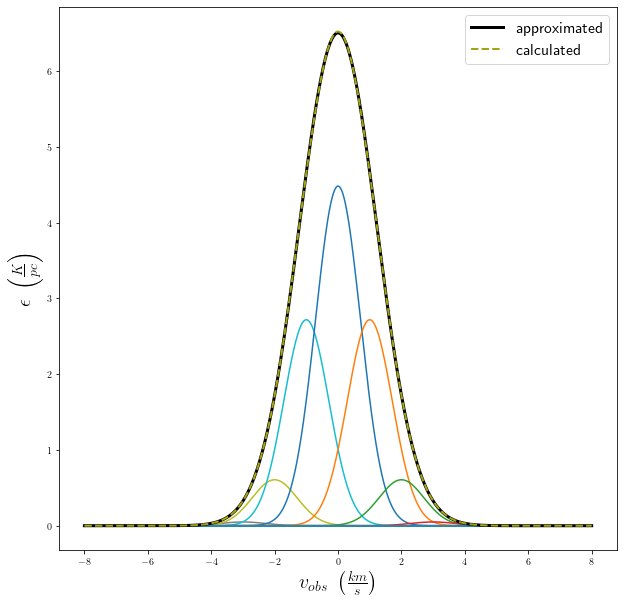

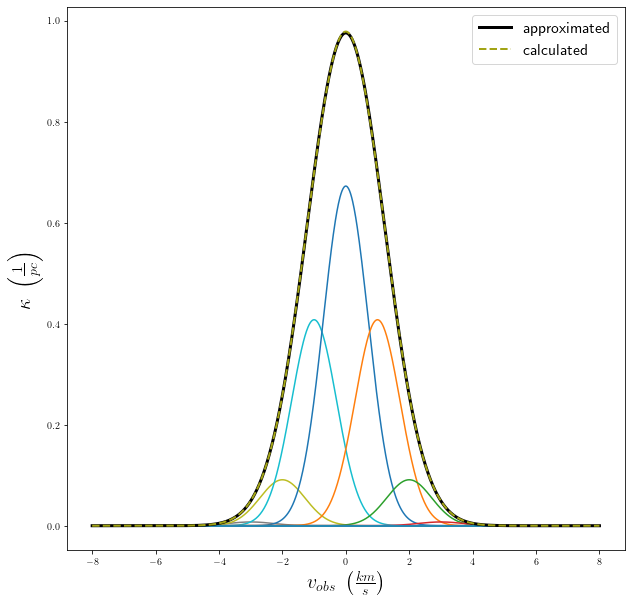

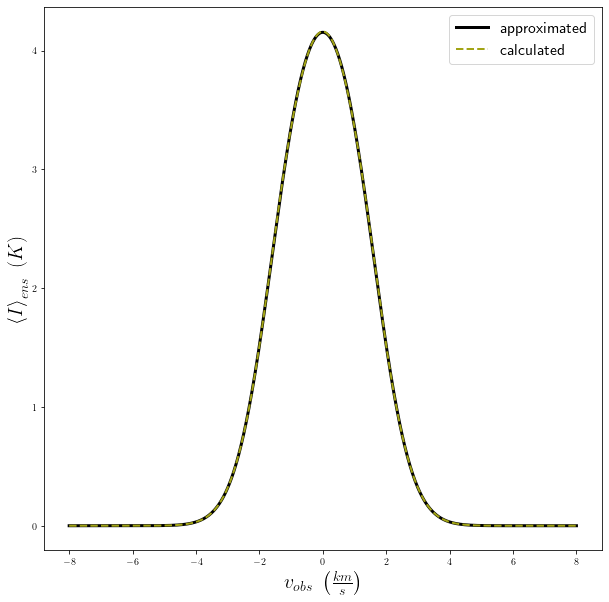

In [16]:
# n_j = 100
# sigma_ens = 2
# sigma_cl = 0.71
# n_v = 1
# v_vox = 0
# v_i = np.linspace(-10, 10, num=21)

# ds = 1
# eps_j = 10
# kap_j = 0.7

# fontsize = 20
# old_computation = False
# incorrect_computation = False
# plot_all = True

v_i = np.linspace(-10, 10, num=21)

ensemble_n, v_i = delta_n_ji(n_j, sigma_ens, v_i=v_i, v_vox=v_vox, n_gauss=n_gauss)
dv = v_i[1]-v_i[0]
v_obs = np.linspace(-8, 8, num=1000)

eps = np.sum([n_j[j]*eps_j[j] / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
eps_ens = np.zeros_like(eps)
if plot_all:
    fig, ax = plt.subplots(1, 1, figsize=figsize)
for i, v_cl in enumerate(v_i):
    if old_computation:
        eps_i = [ensemble_n[j, i]*eps_j[j]*dv * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(n_j))]
    elif incorrect_computation:
        eps_i = [ensemble_n[j, i]*eps_j[j] * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(n_j))]
    else:
        eps_i = [ensemble_n[j, i]*eps_j[j]*dv / np.sqrt(2*np.pi*sigma_cl**2) * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(n_j))]
    if plot_all:
        ax.plot(v_obs, np.sum(eps_i, axis=0))
    eps_ens += np.sum(eps_i, axis=0)
if plot_all:
    ax.plot(v_obs, eps, lw=3, c='xkcd:black', label='approximated')
    ax.plot(v_obs, eps_ens, ls='--', lw=2, c='xkcd:vomit', label='calculated')
    ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    ax.set_ylabel(r'$\epsilon \ \left( \frac{K}{pc} \right)$', fontsize=fontsize)
    ax.legend(fontsize=fontsize*legend_factor)

kap = np.sum([n_j[j]*kap_j[j] / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
kap_ens = np.zeros_like(eps)
if plot_all:
    fig, ax = plt.subplots(1, 1, figsize=figsize)
for i, v_cl in enumerate(v_i):
    if old_computation:
        kap_i = [ensemble_n[j, i]*kap_j[j]*dv * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(n_j))]
    elif incorrect_computation:
        kap_i = [ensemble_n[j, i]*kap_j[j] * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(n_j))]
    else:
        kap_i = [ensemble_n[j, i]*kap_j[j]*dv / np.sqrt(2*np.pi*sigma_cl**2) * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(n_j))]
    if plot_all:
        ax.plot(v_obs, np.sum(kap_i, axis=0))
    # kap_ens += np.exp(-kap_i*ds)
    kap_ens += np.sum(kap_i, axis=0)
# kap_ens = -np.log(kap_ens)/ds
if plot_all:
    ax.plot(v_obs, kap, lw=3, c='xkcd:black', label='approximated')
    ax.plot(v_obs, kap_ens, ls='--', lw=2, c='xkcd:vomit', label='calculated')
    ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    ax.set_ylabel(r'$\kappa \ \left( \frac{1}{pc} \right)$', fontsize=fontsize)
    ax.legend(fontsize=fontsize*legend_factor)

fig, ax = plt.subplots(1, 1, figsize=figsize)
intensity = eps/kap * (1-np.exp(-kap*ds))
intensity_ens = eps_ens/kap_ens * (1-np.exp(-kap_ens*ds))
ax.plot(v_obs, intensity, lw=3, c='xkcd:black', label='approximated')
ax.plot(v_obs, intensity_ens, ls='--', lw=2, c='xkcd:vomit', label='calculated')
ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
ax.set_ylabel(r'$\left< I \right>_{ens} \ \left( K \right)$', fontsize=fontsize)
ax.legend(fontsize=fontsize*legend_factor)

print('Integrated intensity (no discretisation):', np.trapz(intensity, v_obs))
print('Integrated intensity (with discretisation):', np.trapz(intensity_ens, v_obs))

In [17]:
ensemble_n[:, 0].shape

(1,)

The final plot is computed using the radiative transfer equation for a voxel with side length $\Delta s$:

$$
I \left( v_{obs} \right) = \frac{\epsilon \left( v_{obs} \right)}{\kappa \left( v_{obs} \right)} \ e^{- \kappa \left( v_{obs} \right) \Delta s}
$$

The initial factor should equate to a constant provided the emissivity and opacity are Gaussian profiles as expected. One issue with the single-voxel model is that this factor is not equating to a constant with $v_{obs}$, so we will examine it here.

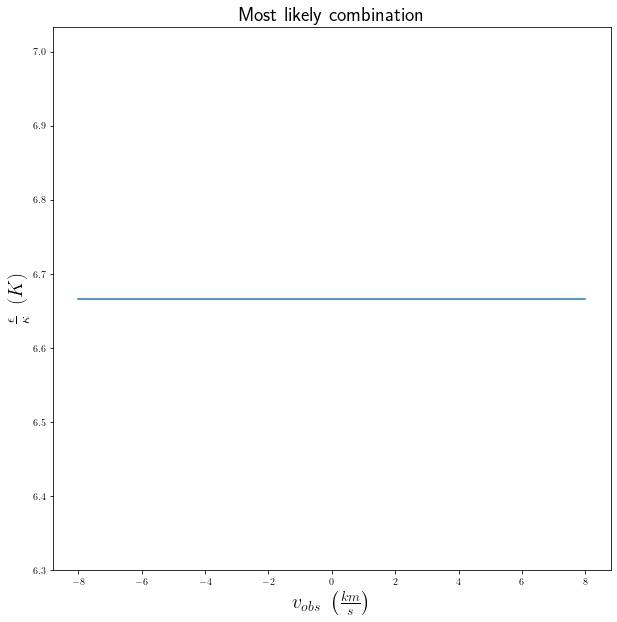

In [18]:
plt.figure(figsize=figsize)
plt.plot(v_obs, eps/kap)
plt.title('Most likely combination', fontsize=fontsize)
plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
plt.ylabel(r'$\frac{\epsilon}{\kappa} \ \left( K \right)$', fontsize=fontsize) ;

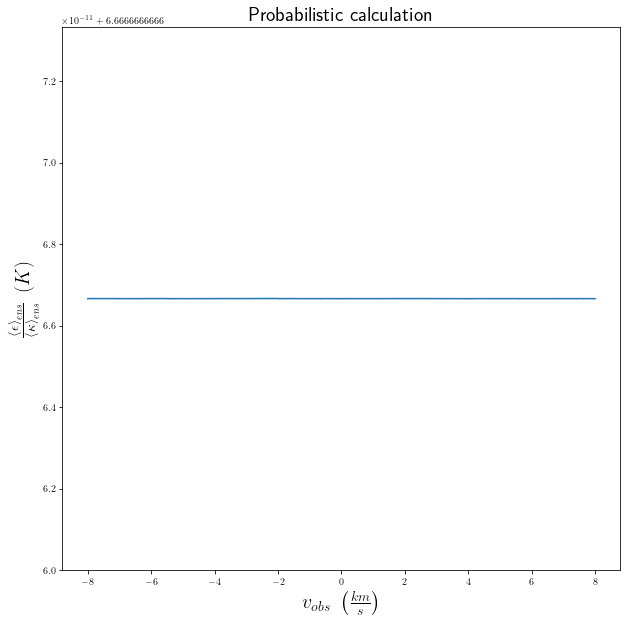

In [19]:
plt.figure(figsize=figsize)
plt.plot(v_obs, eps_ens/kap_ens)
plt.title('Probabilistic calculation', fontsize=fontsize)
plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
plt.ylabel(r'$\frac{\left< \epsilon \right>_{ens}}{\left< \kappa \right>_{ens}} \ \left( K \right)$', fontsize=fontsize) ;

So this discretisation appears to be appropriate for estimating the overall structure of the emission.

### Using a finer discretisation

Now we may us the same functions, but this time we specify that internal velocity grid that should be evalvulated automatically with our given value of $n_{velocity}$.

In [20]:
ensemble_n, v_i = delta_n_ji(n_j, sigma_ens, v_i=None, v_vox=v_vox, n_gauss=n_gauss, n_v=n_v)
dv = v_i[1]-v_i[0]

In [21]:
ensemble_n.sum() * dv

1.9999990518353608

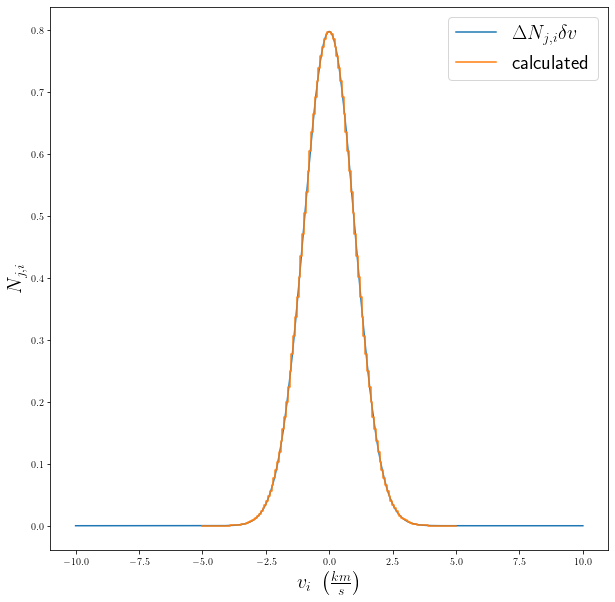

In [22]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
v = np.linspace(v_vox-10, v_vox+10, num=1000)
n = np.sum([n / np.sqrt(2*np.pi*sigma_ens**2) * np.exp(-(v_vox-v)**2/2/sigma_ens**2) for n in n_j], axis=0)
ax.plot(v, n, label=r'$\Delta N_{j,i} \delta v$')
ax.step(v_i, ensemble_n.sum(0), where='mid', label='calculated')
ax.set_xlabel(r'$v_i \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
ax.set_ylabel(r'$N_{j,i}$', fontsize=fontsize)
ax.legend(fontsize=fontsize) ;

Integrated intensity (no discretisation): 14.603788949754605
Integrated intensity (with discretisation): 14.603779478799126


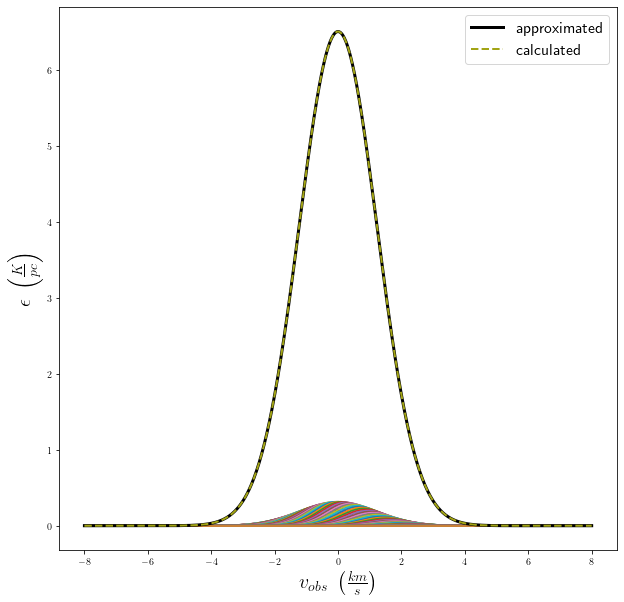

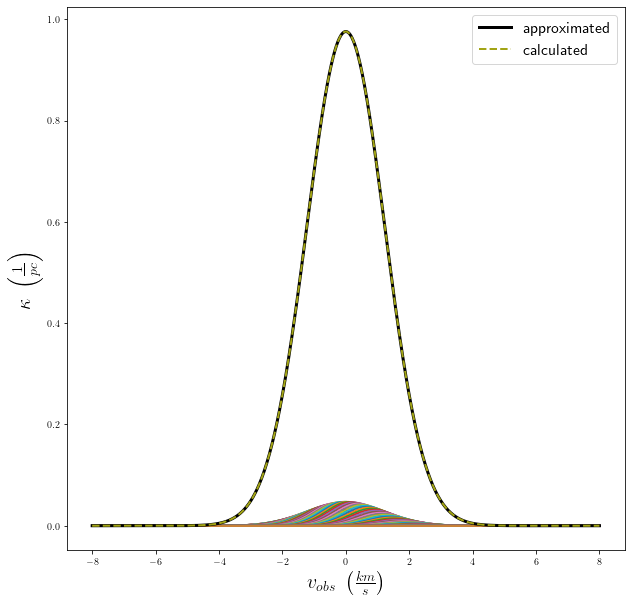

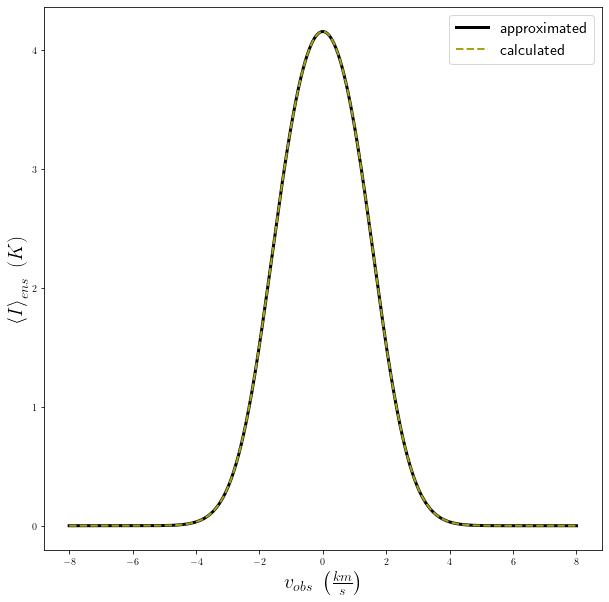

In [23]:
# n_j = 100
# sigma_ens = 2
# sigma_cl = 0.71
# n_v = 1
# v_vox = 0
# v_i = np.linspace(-10, 10, num=21)

# ds = 1
# eps_j = 10
# kap_j = 0.7

# fontsize = 20
# old_computation = False
# incorrect_computation = False
# plot_all = True

ensemble_n, v_i = delta_n_ji(n_j, sigma_ens, v_i=None, v_vox=v_vox, n_gauss=n_gauss, n_v=n_v)
dv = v_i[1]-v_i[0]
v_obs = np.linspace(-8, 8, num=1000)

eps = np.sum([n_j[j]*eps_j[j] / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
eps_ens = np.zeros_like(eps)
if plot_all:
    fig, ax = plt.subplots(1, 1, figsize=figsize)
for i, v_cl in enumerate(v_i):
    if old_computation:
        eps_i = [ensemble_n[j, i]*eps_j[j]*dv * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(n_j))]
    elif incorrect_computation:
        eps_i = [ensemble_n[j, i]*eps_j[j] * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(n_j))]
    else:
        eps_i = [ensemble_n[j, i]*eps_j[j]*dv / np.sqrt(2*np.pi*sigma_cl**2) * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(n_j))]
    if plot_all:
        ax.plot(v_obs, np.sum(eps_i, axis=0))
    eps_ens += np.sum(eps_i, axis=0)
if plot_all:
    ax.plot(v_obs, eps, lw=3, c='xkcd:black', label='approximated')
    ax.plot(v_obs, eps_ens, ls='--', lw=2, c='xkcd:vomit', label='calculated')
    ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    ax.set_ylabel(r'$\epsilon \ \left( \frac{K}{pc} \right)$', fontsize=fontsize)
    ax.legend(fontsize=fontsize*legend_factor)

kap = np.sum([n_j[j]*kap_j[j] / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
kap_ens = np.zeros_like(eps)
if plot_all:
    fig, ax = plt.subplots(1, 1, figsize=figsize)
for i, v_cl in enumerate(v_i):
    if old_computation:
        kap_i = [ensemble_n[j, i]*kap_j[j]*dv * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(n_j))]
    elif incorrect_computation:
        kap_i = [ensemble_n[j, i]*kap_j[j] * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(n_j))]
    else:
        kap_i = [ensemble_n[j, i]*kap_j[j]*dv / np.sqrt(2*np.pi*sigma_cl**2) * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(n_j))]
    if plot_all:
        ax.plot(v_obs, np.sum(kap_i, axis=0))
    kap_ens += np.sum(kap_i, axis=0)
if plot_all:
    ax.plot(v_obs, kap, lw=3, c='xkcd:black', label='approximated')
    ax.plot(v_obs, kap_ens, ls='--', lw=2, c='xkcd:vomit', label='calculated')
    ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    ax.set_ylabel(r'$\kappa \ \left( \frac{1}{pc} \right)$', fontsize=fontsize)
    ax.legend(fontsize=fontsize*legend_factor)

fig, ax = plt.subplots(1, 1, figsize=figsize)
intensity = eps/kap * (1-np.exp(-kap*ds))
intensity_ens = eps_ens/kap_ens * (1-np.exp(-kap_ens*ds))
ax.plot(v_obs, intensity, lw=3, c='xkcd:black', label='approximated')
ax.plot(v_obs, intensity_ens, ls='--', lw=2, c='xkcd:vomit', label='calculated')
ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
ax.set_ylabel(r'$\left< I \right>_{ens} \ \left( K \right)$', fontsize=fontsize)
ax.legend(fontsize=fontsize*legend_factor)

print('Integrated intensity (no discretisation):', np.trapz(intensity, v_obs))
print('Integrated intensity (with discretisation):', np.trapz(intensity_ens, v_obs))

Judging by the calculated $\varpi \equiv \int I dv$, this method performs with the same accuracy.

Below we see that these approximations of the ensemble intensity both follow the same Gaussian distribution, since the factor of $\frac{\epsilon_{ens}}{\kappa_{ens}}$ is constant.

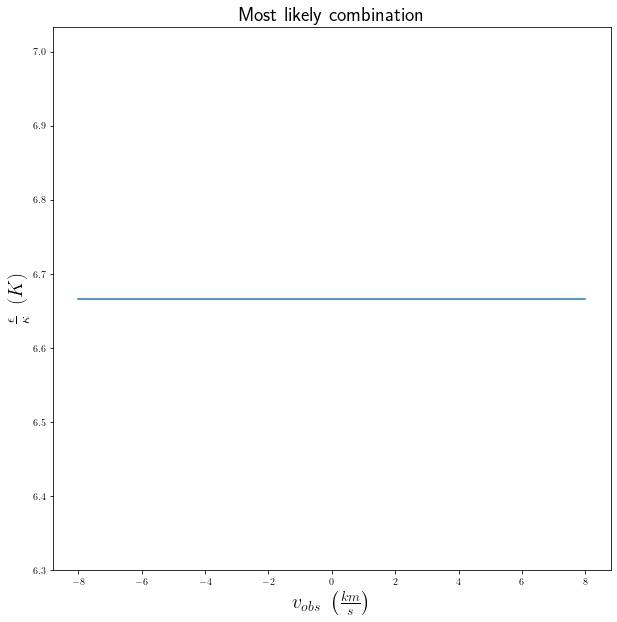

In [24]:
plt.figure(figsize=figsize)
plt.plot(v_obs, eps/kap)
plt.title('Most likely combination', fontsize=fontsize)
plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
plt.ylabel(r'$\frac{\epsilon}{\kappa} \ \left( K \right)$', fontsize=fontsize) ;

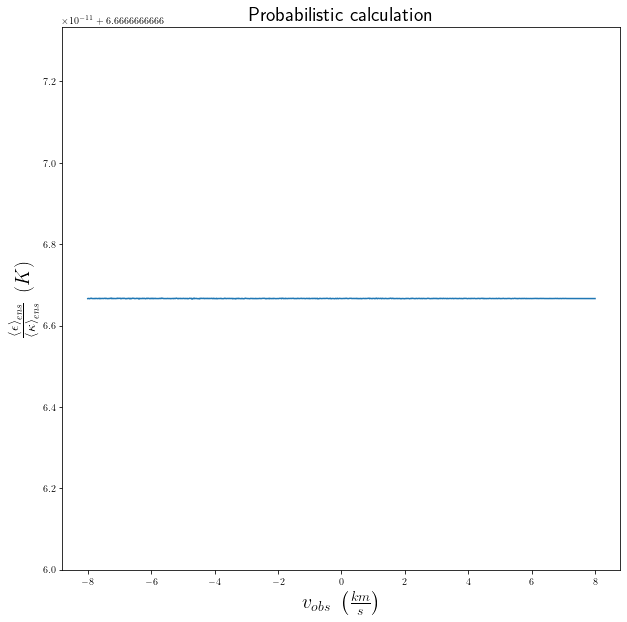

In [25]:
plt.figure(figsize=figsize)
plt.plot(v_obs, eps_ens/kap_ens)
plt.title('Probabilistic calculation', fontsize=fontsize)
plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
plt.ylabel(r'$\frac{\left< \epsilon \right>_{ens}}{\left< \kappa \right>_{ens}} \ \left( K \right)$', fontsize=fontsize) ;

## Probabilistic approach

Thus-far we have merely considered how the discretisation affects the intensity of the ensemble. The full implementation of `kosmatau3d` uses a probabilistic approach to calculate the likelihood of having a given combination $k_{j,i}$ of clumps in your line-of-sight. The probability of each clump depends on its projected area ($\pi R_{cl}^2$) compared with the area of one face of the voxel ($\Delta s$).

$$
p_{j,i} = \binom{\Delta N_{j,i}}{k_{j,i}} \ p_j^{k_{j,i}} \ \left( 1 - p_j \right)^{\Delta N_{j,i} - k_{j,i}}
$$

This probability is then applied to the emissivity and opacity in different ways due to how they enter into the radiative transfer equation. For each systematic velocity,

$$
\left< \epsilon \right>_{i} = \sum_{k} \left( \prod_{j} p_{j,i} \right) \left( \sum_{j} k_{j,i} \epsilon_{j} \right), \\
\left< \kappa \right>_{i} = - \mathrm{log} \left[ \sum_{k} \left( \prod_{j} p_{j,i} \right) \mathrm{exp} \left( - \sum_{j} k_{j,i} \kappa_{j} \Delta s \right) \right] \ \div \ \Delta s.
$$

In [26]:
md(r'Now we wish to apply this procedure to our previous example. Let us assume our clump has a radius of $R_{cl} =$'
   + r'{} $pc$.'.format(r_j))

Now we wish to apply this procedure to our previous example. Let us assume our clump has a radius of $R_{cl} =$[0.5] $pc$.

### With the original discretisation

First we examine how the original discretisation handles a dense voxel.

Integrated intensity (no probabilistic discretisation): 12.210055684289864
Integrated intensity (with probabilistic discretisation): 12.661741961058125


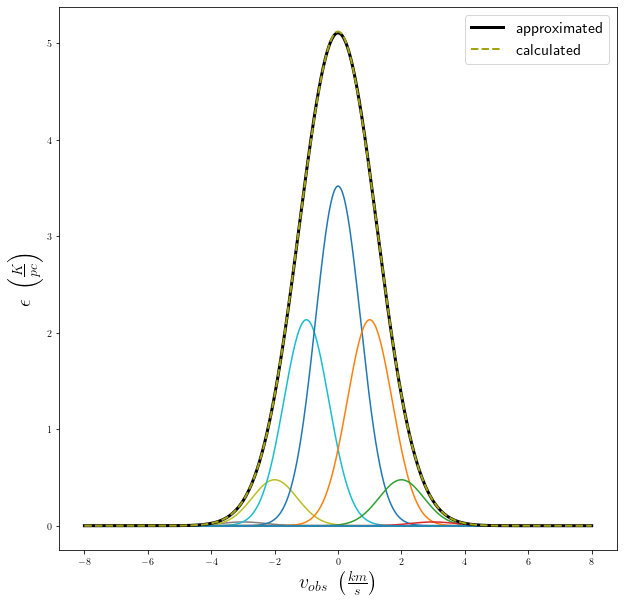

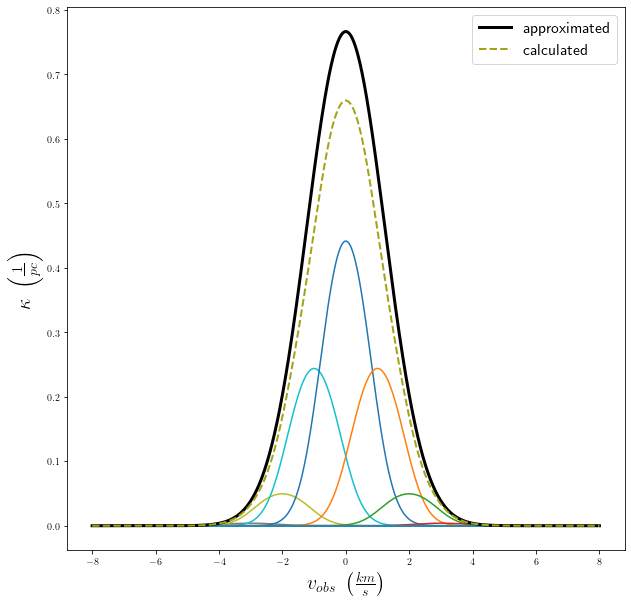

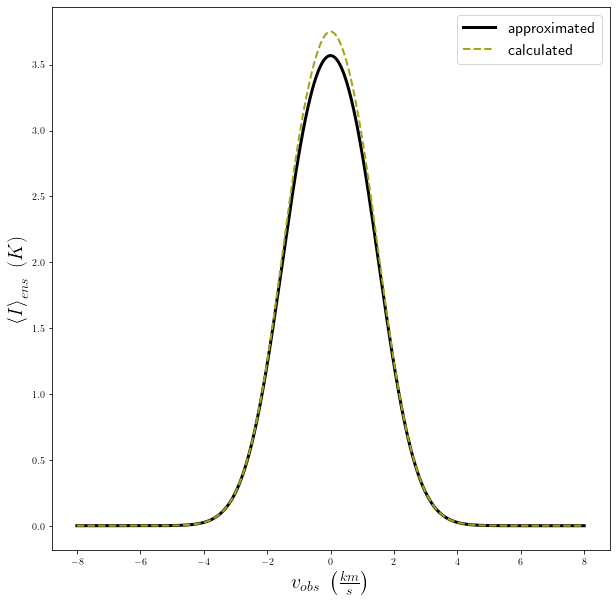

In [27]:
# n_j = 100
# sigma_ens = 2
# sigma_cl = 0.71
# n_v = 3
# v_vox = 0
# v_i = np.linspace(-10, 10, num=21)

# r_j = 0.5
# ds = 1

# ds = 1
# eps_j = 10
# kap_j = 1.5

# fontsize = 20
# old_computation = False
# incorrect_computation = False
# test_opacity = True
# plot_all = True

v_i = np.linspace(-10, 10, num=21)

p_j = np.asarray([np.pi*r**2/ds**2 for r in r_j])
x = [np.arange(0, n+1) for n in n_j]
x_mesh = np.asarray([comb.flatten() for comb in np.meshgrid(*x)])
y = [binom.pmf(x_mesh[j], n_j[j], p_j[j]) for j in range(len(n_j))]
prob = np.prod(y, axis=0)
if prob[-1] == prob.max():
    n_ens = p_j * x_mesh[:, prob.argmax()]
else:
    n_ens = x_mesh[:, prob.argmax()]

ensemble_n, v_i = delta_n_ji(n_j, sigma_ens, v_i=v_i, v_vox=v_vox, n_gauss=n_gauss)
dv = v_i[1]-v_i[0]
p_ji, k_ji = probability(r_j, ds=ds, delta_n_ji=ensemble_n)
v_obs = np.linspace(-8, 8, num=1000)

eps = np.sum([n_ens[j]*eps_j[j] / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_ens))], axis=0)
eps_ens = np.zeros_like(eps)
if plot_all:
    fig, ax = plt.subplots(1, 1, figsize=figsize)
for i, v_cl in enumerate(v_i):
    p_j = np.array([p_ji[j, i] for j in range(p_ji.shape[0])], dtype=float)
    k_j = np.array([k_ji[j, i] for j in range(k_ji.shape[0])], dtype=int)
    if np.isnan(p_j).any():
        continue
    if old_computation:
        eps_i = [k_j[j].reshape(-1, 1)*eps_j[j]*dv * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(k_j))]
    elif incorrect_computation:
        eps_i = [k_j[j].reshape(-1, 1)*eps_j[j] * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(k_j))]
    else:
        eps_i = [k_j[j].reshape(-1, 1)*eps_j[j]*dv / np.sqrt(2*np.pi*sigma_cl**2) * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(k_j))]
    if plot_all:
        ax.plot(v_obs, (p_j.prod(0).reshape(-1, 1)*np.sum(eps_i, axis=0)).sum(0))
    eps_ens += (p_j.prod(0).reshape(-1, 1)*np.sum(eps_i, axis=0)).sum(0)
    # eps_ens += ((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1)*np.sum(eps_i, axis=0)).sum(0)
if plot_all:
    ax.plot(v_obs, eps, lw=3, c='xkcd:black', label='approximated')
    ax.plot(v_obs, eps_ens, ls='--', lw=2, c='xkcd:vomit', label='calculated')
    ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    ax.set_ylabel(r'$\epsilon \ \left( \frac{K}{pc} \right)$', fontsize=fontsize)
    ax.legend(fontsize=fontsize*legend_factor)

kap = np.sum([n_ens[j]*kap_j[j] / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_ens))], axis=0)
kap_ens = np.zeros_like(eps)
if plot_all:
    fig, ax = plt.subplots(1, 1, figsize=figsize)
for i, v_cl in enumerate(v_i):
    p_j = np.array([p_ji[j, i] for j in range(p_ji.shape[0])], dtype=float)
    k_j = np.array([k_ji[j, i] for j in range(k_ji.shape[0])], dtype=int)
    if np.isnan(p_j).any():
        continue
    if old_computation:
        kap_i = np.asarray([k_j[j].reshape(-1, 1)*kap_j[j]*dv * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(k_j))])
    elif incorrect_computation:
        kap_i = np.asarray([k_j[j].reshape(-1, 1)*kap_j[j] * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(k_j))])
    else:
        kap_i = np.asarray([k_j[j].reshape(-1, 1)*kap_j[j]*dv / np.sqrt(2*np.pi*sigma_cl**2) * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(k_j))])
    if plot_all and test_opacity:
        ax.plot(v_obs, (p_j.prod(0).reshape(-1, 1)*np.sum(kap_i, axis=0)).sum(0))
    elif plot_all:
        ax.plot(v_obs, -np.log((p_j.prod(0).reshape(-1, 1)*np.exp(-np.sum(kap_i, axis=0)*ds)).sum(0))/ds)
    if test_opacity:
        kap_ens += ((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1)*np.sum(kap_i, axis=0)).sum(0)
    else:
        kap_ens += -np.log(((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1)*np.exp(-np.sum(kap_i, axis=0)*ds)).sum(0))/ds
if plot_all:
    ax.plot(v_obs, kap, lw=3, c='xkcd:black', label='approximated')
    ax.plot(v_obs, kap_ens, ls='--', lw=2, c='xkcd:vomit', label='calculated')
    ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    ax.set_ylabel(r'$\kappa \ \left( \frac{1}{pc} \right)$', fontsize=fontsize)
    ax.legend(fontsize=fontsize*legend_factor)

fig, ax = plt.subplots(1, 1, figsize=figsize)
intensity = np.nan_to_num(eps/kap * (1-np.exp(-kap*ds)))
intensity_ens = np.nan_to_num(eps_ens/kap_ens * (1-np.exp(-kap_ens*ds)))
ax.plot(v_obs, intensity, lw=3, c='xkcd:black', label='approximated')
ax.plot(v_obs, intensity_ens, ls='--', lw=2, c='xkcd:vomit', label='calculated')
ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
ax.set_ylabel(r'$\left< I \right>_{ens} \ \left( K \right)$', fontsize=fontsize)
ax.legend(fontsize=fontsize*legend_factor)

print('Integrated intensity (no probabilistic discretisation):', np.trapz(intensity, v_obs))
print('Integrated intensity (with probabilistic discretisation):', np.trapz(intensity_ens, v_obs))

[2]


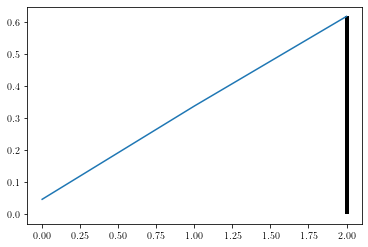

In [28]:
p_j = [np.pi*r**2/ds**2 for r in r_j]
x = [np.arange(0, n+1) for n in n_j]
x_mesh = np.asarray([comb.flatten() for comb in np.meshgrid(*x)])
y = [binom.pmf(x_mesh[j], n_j[j], p_j[j]) for j in range(len(n_j))]
prob = np.prod(y, axis=0)
i_max = prob.argmax()
n_ens = x_mesh[:, i_max]

plt.plot(prob[:100])
plt.vlines(i_max, 0, prob.max(), lw=4, color='xkcd:black')
print(n_ens)

As it can be seen, there are some wavy features on top of the absorption feature. So far as I can tell from the overall development of `kosmatau3d`, this is due to slight deviations of $\epsilon$ and $\kappa$ from a Gaussian distribution. The initial fraction in the radiative transfer equation, $\left( \frac{\epsilon}{\kappa} \right)$, should cancel out the Gaussian structure and equate to a constant. Now in the probabilistic discretisation, $\left< \epsilon \right>_{ens}$ and $\left< \kappa \right>_{ens}$ are not perfect Gaussians but follow a similar structure. For that reason we are mainly concerned with the smoothness of this initial fraction. When it has wavy features, the resulting intensity $\left< I \right>_{vox} \left( v_{obs} \right)$ will also have these wavy features.

Plots of this fraction can be seen below.

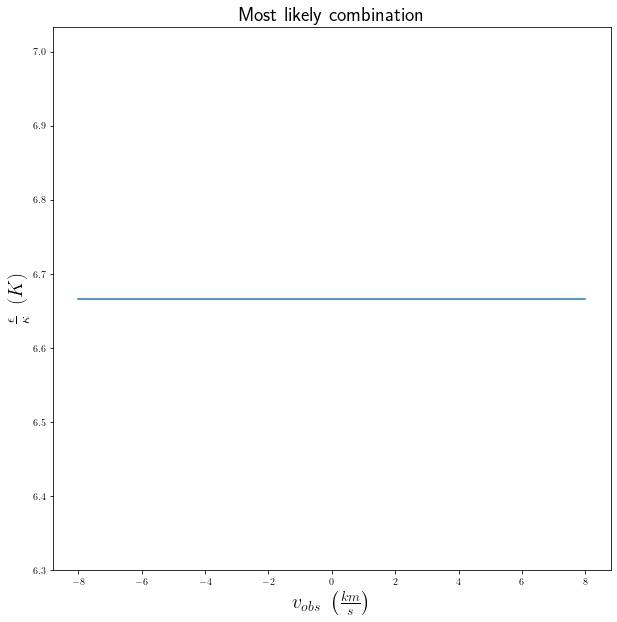

In [29]:
plt.figure(figsize=figsize)
plt.plot(v_obs, eps/kap)
plt.title('Most likely combination', fontsize=fontsize)
plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
plt.ylabel(r'$\frac{\epsilon}{\kappa} \ \left( K \right)$', fontsize=fontsize) ;

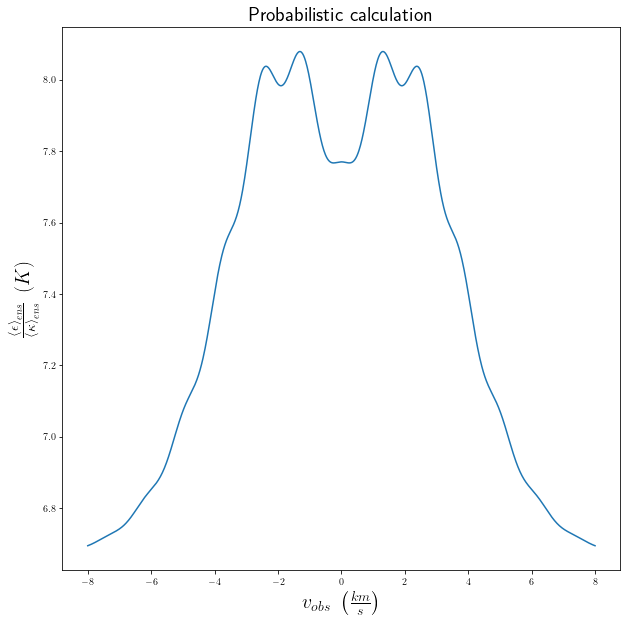

In [30]:
plt.figure(figsize=figsize)
plt.plot(v_obs, eps_ens/kap_ens)
plt.title('Probabilistic calculation', fontsize=fontsize)
plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
plt.ylabel(r'$\frac{\left< \epsilon \right>_{ens}}{\left< \kappa \right>_{ens}} \ \left( K \right)$', fontsize=fontsize) ;

### Using a finer discretisation

Using a higher velocity resolution in the model should remove this wavy feature in the resulting $\left< I \right>_{vox} (v_{obs})$.

Integrated intensity (no probabilistic discretisation): 12.210055684289864
Integrated intensity (with probabilistic discretisation): 12.242554654202287


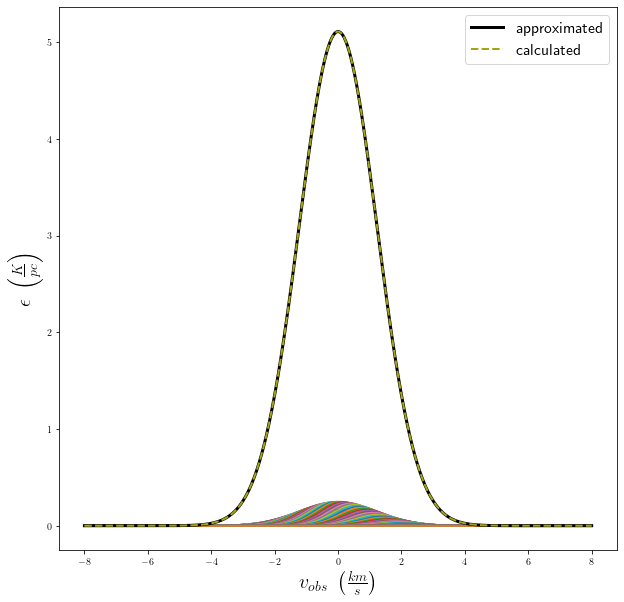

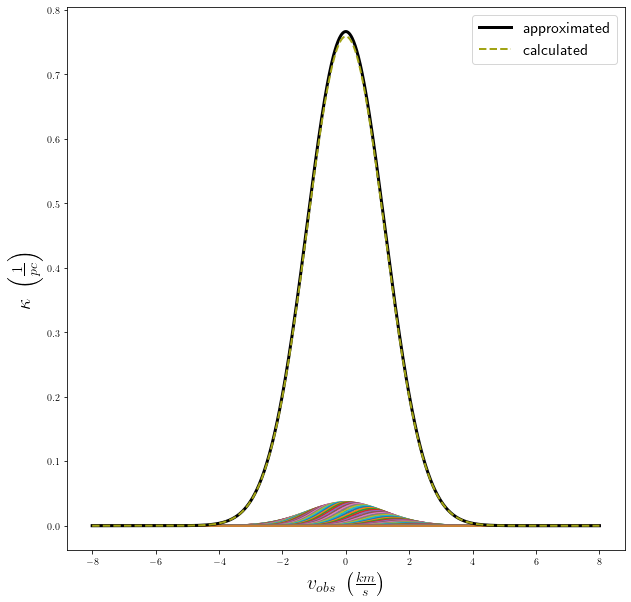

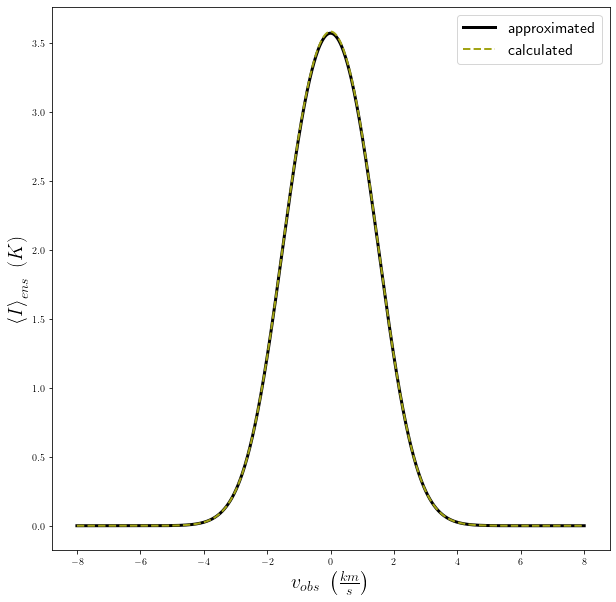

In [31]:
# n_j = 100
# sigma_ens = 2
# sigma_cl = 0.71
# n_v = 3
# v_vox = 0

# r_j = 0.5
# ds = 1

# ds = 1
# eps_j = 10
# kap_j = 1.5

# fontsize = 20
# old_computation = False
# incorrect_computation = False
# plot_all = True

p_j = np.asarray([np.pi*r**2/ds**2 for r in r_j])
x = [np.arange(0, n+1) for n in n_j]
x_mesh = np.asarray([comb.flatten() for comb in np.meshgrid(*x)])
y = np.asarray([binom.pmf(x_mesh[j], n_j[j], p_j[j]) for j in range(len(n_j))])
prob = np.prod(y, axis=0)
if prob[-1] == prob.max():
    n_ens = p_j * x_mesh[:, prob.argmax()]
else:
    n_ens = x_mesh[:, prob.argmax()]

ensemble_n, v_i = delta_n_ji(n_j, sigma_ens, v_i=None, v_vox=v_vox, n_gauss=n_gauss, n_v=n_v)
dv = v_i[1]-v_i[0]
p_ji, k_ji = probability(r_j, ds=ds, delta_n_ji=ensemble_n)
v_obs = np.linspace(-8, 8, num=1000)

eps = np.sum([n_ens[j]*eps_j[j] / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_ens))], axis=0)
eps_ens = np.zeros_like(eps)
if plot_all:
    fig, ax = plt.subplots(1, 1, figsize=figsize)
for i, v_cl in enumerate(v_i):
    p_j = np.array([p_ji[j, i] for j in range(p_ji.shape[0])], dtype=float)
    k_j = np.array([k_ji[j, i] for j in range(k_ji.shape[0])], dtype=int)
    if np.isnan(p_j).any():
        continue
    if old_computation:
        eps_i = [k_j[j].reshape(-1, 1)*eps_j[j]*dv * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(k_j))]
    elif incorrect_computation:
        eps_i = [k_j[j].reshape(-1, 1)*eps_j[j] * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(k_j))]
    else:
        eps_i = [k_j[j].reshape(-1, 1)*eps_j[j]*dv / np.sqrt(2*np.pi*sigma_cl**2) * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(k_j))]
    if plot_all:
        ax.plot(v_obs, (p_j.prod(0).reshape(-1, 1)*np.sum(eps_i, axis=0)).sum(0))
    eps_ens += (p_j.prod(0).reshape(-1, 1)*np.sum(eps_i, axis=0)).sum(0)
    # eps_ens += ((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1)*np.sum(eps_i, axis=0)).sum(0)
if plot_all:
    ax.plot(v_obs, eps, lw=3, c='xkcd:black', label='approximated')
    ax.plot(v_obs, eps_ens, ls='--', lw=2, c='xkcd:vomit', label='calculated')
    ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    ax.set_ylabel(r'$\epsilon \ \left( \frac{K}{pc} \right)$', fontsize=fontsize)
    ax.legend(fontsize=fontsize*legend_factor)

kap = np.sum([n_ens[j]*kap_j[j] / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_ens))], axis=0)
kap_ens = np.zeros_like(eps)
if plot_all:
    fig, ax = plt.subplots(1, 1, figsize=figsize)
for i, v_cl in enumerate(v_i):
    p_j = np.array([p_ji[j, i] for j in range(p_ji.shape[0])], dtype=float)
    k_j = np.array([k_ji[j, i] for j in range(k_ji.shape[0])], dtype=int)
    if np.isnan(p_j).any():
        continue
    if old_computation:
        kap_i = np.asarray([k_j[j].reshape(-1, 1)*kap_j[j]*dv * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(k_j))])
    elif incorrect_computation:
        kap_i = np.asarray([k_j[j].reshape(-1, 1)*kap_j[j] * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(k_j))])
    else:
        kap_i = np.asarray([k_j[j].reshape(-1, 1)*kap_j[j]*dv / np.sqrt(2*np.pi*sigma_cl**2) * np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for j in range(len(k_j))])
    if plot_all and test_opacity:
        ax.plot(v_obs, (p_j.prod(0).reshape(-1, 1)*np.sum(kap_i, axis=0)).sum(0))
    elif plot_all:
        ax.plot(v_obs, -np.log((p_j.prod(0).reshape(-1, 1)*np.exp(-np.sum(kap_i, axis=0)*ds)).sum(0))/ds)
    if test_opacity:
        kap_ens += ((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1)*np.sum(kap_i, axis=0)).sum(0)
    else:
        kap_ens += -np.log(((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1)*np.exp(-np.sum(kap_i, axis=0)*ds)).sum(0))/ds
if plot_all:
    ax.plot(v_obs, kap, lw=3, c='xkcd:black', label='approximated')
    ax.plot(v_obs, kap_ens, ls='--', lw=2, c='xkcd:vomit', label='calculated')
    ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    ax.set_ylabel(r'$\kappa \ \left( \frac{1}{pc} \right)$', fontsize=fontsize)
    ax.legend(fontsize=fontsize*legend_factor)

fig, ax = plt.subplots(1, 1, figsize=figsize)
intensity = eps/kap * (1-np.exp(-kap*ds))
intensity_ens = eps_ens/kap_ens * (1-np.exp(-kap_ens*ds))
ax.plot(v_obs, intensity, lw=3, c='xkcd:black', label='approximated')
ax.plot(v_obs, intensity_ens, ls='--', lw=2, c='xkcd:vomit', label='calculated')
ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
ax.set_ylabel(r'$\left< I \right>_{ens} \ \left( K \right)$', fontsize=fontsize)
ax.legend(fontsize=fontsize*legend_factor)

print('Integrated intensity (no probabilistic discretisation):', np.trapz(intensity, v_obs))
print('Integrated intensity (with probabilistic discretisation):', np.trapz(intensity_ens, v_obs))

In [32]:
y.argmax(1).shape

(1,)

In [33]:
n_ens.shape

(1,)

In [34]:
p_j.shape

(1, 2)

In [35]:
x_mesh[:, y.prod(0).argmax()].shape

(1,)

In [36]:
x_mesh[:, y.argmax(1)].shape

(1, 1)

[2]


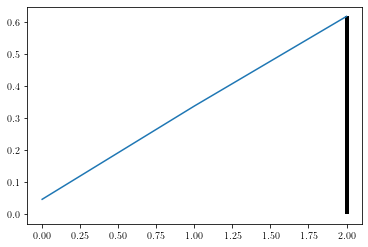

In [37]:
p_j = [np.pi*r**2/ds**2 for r in r_j]
x = [np.arange(0, n+1) for n in n_j]
x_mesh = np.asarray([comb.flatten() for comb in np.meshgrid(*x)])
y = [binom.pmf(x_mesh[j], n_j[j], p_j[j]) for j in range(len(n_j))]
prob = np.prod(y, axis=0)
i_max = prob.argmax()
n_ens = x_mesh[:, i_max]

plt.plot(prob[:100])
plt.vlines(i_max, 0, prob.max(), lw=4, color='xkcd:black')
print(n_ens)

This looks like the wavy features are no longer an issue. To confirm, let us examine the initial fraction of the radiative transfer equation as in the previous subsection.

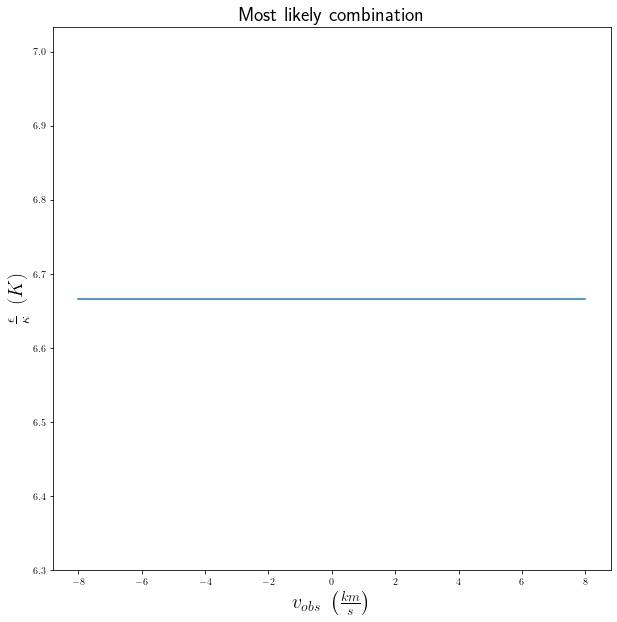

In [38]:
plt.figure(figsize=figsize)
plt.plot(v_obs, eps/kap)
plt.title('Most likely combination', fontsize=fontsize)
plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
plt.ylabel(r'$\frac{\epsilon}{\kappa} \ \left( K \right)$', fontsize=fontsize) ;

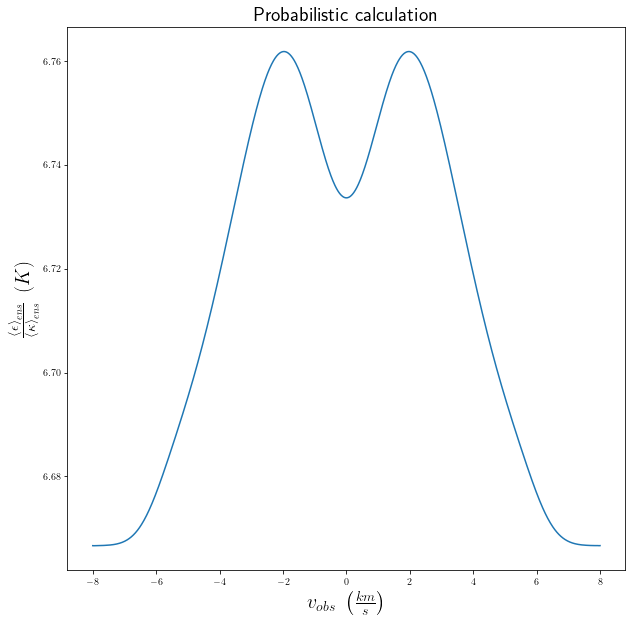

In [39]:
plt.figure(figsize=figsize)
plt.plot(v_obs, eps_ens/kap_ens)
plt.title('Probabilistic calculation', fontsize=fontsize)
plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
plt.ylabel(r'$\frac{\left< \epsilon \right>_{ens}}{\left< \kappa \right>_{ens}} \ \left( K \right)$', fontsize=fontsize) ;

This not only shows that a smooth fraction will result in a smooth absorption feature, but also that $\left< \epsilon \right>_{ens}$ and $\left< \kappa \right>_{ens}$ follow different distributions. To approximate this in terms of a Gaussian, we will perform a fit to examine how much they differ.

In [40]:
from scipy.optimize import curve_fit

def eps_eff(v, a, sigma_eff):
    return np.sum([a * n_ens[cl]*eps_j[cl]/np.sqrt(2*np.pi*sigma_eff**2) * np.exp(-v**2/2/sigma_eff**2) for cl in range(len(n_ens))], axis=0)

def kap_eff(v, a, sigma_eff):
    return np.sum([a * n_ens[cl]*kap_j[cl]/np.sqrt(2*np.pi*sigma_eff**2) * np.exp(-v**2/2/sigma_eff**2) for cl in range(len(n_ens))], axis=0)

In [41]:
a_eps, sigma_eps_eff = curve_fit(eps_eff, v_obs, eps_ens, [1, sigma_ens])[0]
a_kap, sigma_kap_eff = curve_fit(kap_eff, v_obs, kap_ens, [1, sigma_ens])[0]

print('fitted amplitudes:\n{}\n{}\n'.format(a_eps, a_kap))
print('fitted dispersions:\n{}\n{}\n'.format(sigma_eps_eff, sigma_kap_eff))

eps_fit = eps_eff(v_obs, a_eps, sigma_eps_eff)
kap_fit = kap_eff(v_obs, a_kap, sigma_kap_eff)

fitted amplitudes:
0.7853981574666713
0.7759675992813044

fitted dispersions:
1.2264175303753284
1.224530457862508



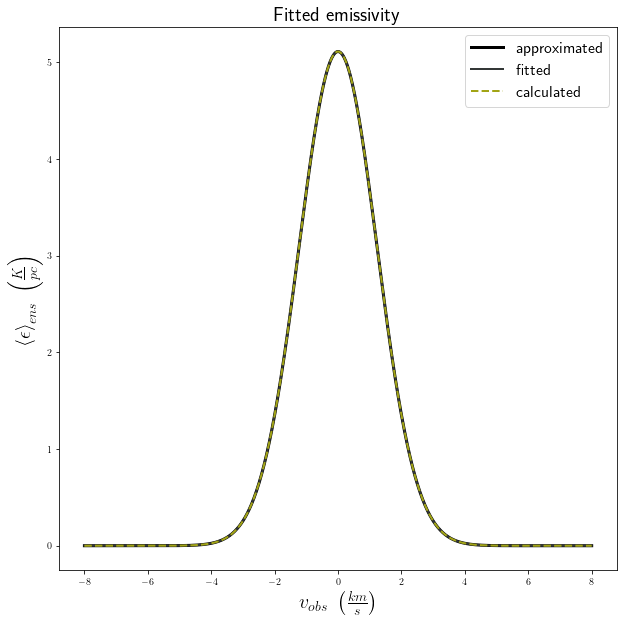

In [42]:
plt.figure(figsize=figsize)
plt.plot(v_obs, eps, c='xkcd:black', lw=3, label='approximated')
plt.plot(v_obs, eps_fit, c='xkcd:charcoal', lw=2, ls='-', label='fitted')
plt.plot(v_obs, eps_ens, c='xkcd:vomit', lw=2, ls='--', label='calculated')
plt.legend(fontsize=fontsize*legend_factor)
plt.title('Fitted emissivity', fontsize=fontsize)
plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
plt.ylabel(r'$\left< \epsilon \right>_{ens} \ \left( \frac{K}{pc} \right)$', fontsize=fontsize) ;

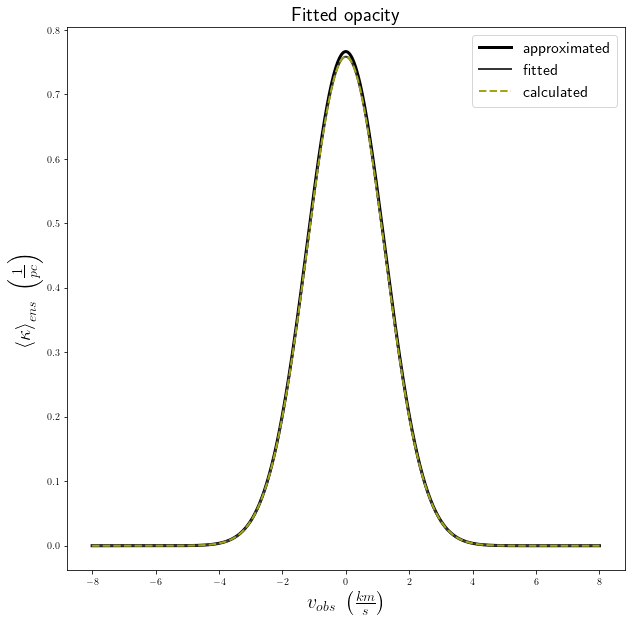

In [43]:
plt.figure(figsize=figsize)
plt.plot(v_obs, kap, c='xkcd:black', lw=3, label='approximated')
plt.plot(v_obs, kap_fit, c='xkcd:charcoal', lw=2, ls='-', label='fitted')
plt.plot(v_obs, kap_ens, c='xkcd:vomit', lw=2, ls='--', label='calculated')
plt.legend(fontsize=fontsize*legend_factor)
plt.title('Fitted opacity', fontsize=fontsize)
plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
plt.ylabel(r'$\left< \kappa \right>_{ens} \ \left( \frac{1}{pc} \right)$', fontsize=fontsize) ;

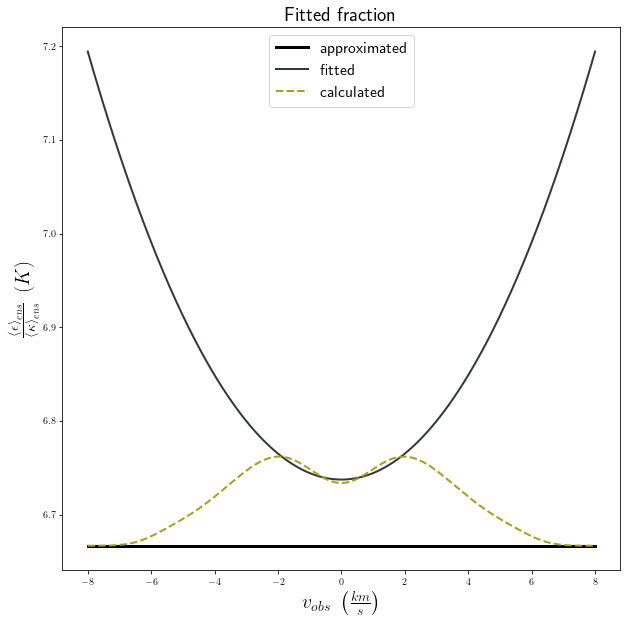

In [44]:
plt.figure(figsize=figsize)
plt.plot(v_obs, eps/kap, c='xkcd:black', lw=3, label='approximated')
plt.plot(v_obs, eps_fit/kap_fit, 
         c='xkcd:charcoal', lw=2, ls='-', label='fitted')
plt.plot(v_obs, eps_ens/kap_ens, c='xkcd:vomit', lw=2, ls='--', label='calculated')
plt.legend(fontsize=fontsize*legend_factor)
plt.title('Fitted fraction', fontsize=fontsize)
plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
plt.ylabel(r'$\frac{\left< \epsilon \right>_{ens}}{\left< \kappa \right>_{ens}} \ \left( K \right)$', fontsize=fontsize) ;

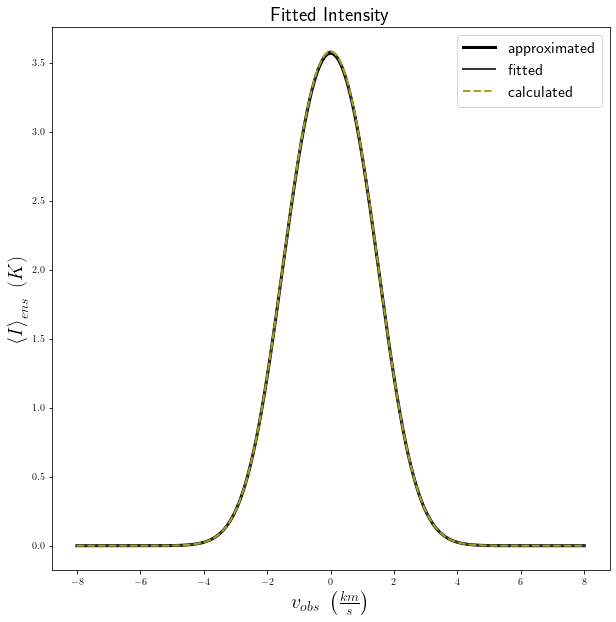

In [45]:
plt.figure(figsize=figsize)
plt.plot(v_obs, eps/kap*(1-np.exp(-kap*ds)), c='xkcd:black', lw=3, label='approximated')
plt.plot(v_obs, eps_fit/kap_fit*(1-np.exp(-kap_fit*ds)), c='xkcd:charcoal', lw=2, ls='-', label='fitted')
plt.plot(v_obs, eps_ens/kap_ens*(1-np.exp(-kap_ens*ds)), c='xkcd:vomit', lw=2, ls='--', label='calculated')
plt.legend(fontsize=fontsize*legend_factor)
plt.title('Fitted Intensity', fontsize=fontsize)
plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
plt.ylabel(r'$\left< I \right>_{ens} \ \left( K \right)$', fontsize=fontsize) ;

## Final remarks

It is clear that the probabilistic approach affects the behaviour of the emissivity and opacity with respect to observing velocity. Using a standard assumption that both the emissivity and the absorption follow the same Gaussian distribution with velocity dispersion $\sigma_{ens, eff}$, their ratio will cause the Gaussian distribution to cancel and the result will be a value constant with respect to observing velocity. If we assume the emissivity and opacity follow two slightly different Gaussians (as in the fitted values), then the ratio will also have a Gaussian structure. What seems to be happening in the probabilistic approach is that the voxel-averaged emissivity follows a more strongly-peaked Gaussian than the voxel-averaged opacity near the center velocity, whereas they follow the same Gaussian distribution far away from the center velocity. The pseudo-Gaussian behaviour of these values appear to cause the steep edges in the wings of the intensity plot. The fitted emissivity and opacity are very close to the voxel-averaged values, but they are unable to capture these sharp wings.

In the end, we have to decide what how the model should work. If we just want the single-voxel model to model the emissivity and opacity as simple Gaussians, then much of the complexity in `kosmatau3d` can be removed. Personally, I think that one of the advantages in the probabilistic clumpy distribution is that it is more complex than a simple Gaussian. Therefore, if there is insufficient reason to alter this approach, I am in favour of keeping the complexity of the probabilistic approach (even if it is computationally demanding).

Another implementation suggestion is to remove the internal velocity grid entirely and use a modified $\sigma_{ens}$ in the exponent (as attempted in the fitting function) when calculating the number of clumps. It is sufficiently shown above that approximating the clumps in a line-of-sight by finding the most-probable combination works suitably-well for approximating the intensity of the voxel, does not suffer from the discretisation artefacts of the internal velocity grid, and is much more computationally-efficient. There is a slight issue regarding low clump numbers...

In conclusion, the voxel intensity calculation should be restructured to adopt this more-efficient method. This will also help reduce the immense complexity of the code (particularily in the `ensemble` submodule).